# Exercise 2.11

Several "Los Pollos Hermanos" vans, carrying large quantities of methamphetamine (meth), were attacked by a drug cartel 10 times in an area in New Mexico. The DEA thinks the meth lab is at the centroid of this area.
* Randomly generate the attacks’ points in New Mexico
* Compute the smallest polygon that contains all the points corresponding to the attacks
* Create a GeometryCollection that contains New Mexico, the polygon, and the points within it
* Visualize the collection and the centroid in folium (use markers for points, color the centroid differently)
* Submit a (well-commented) notebook

## Installing the packages

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 323 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 4.8 MB/s 
     |███████████████

## Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to download and extract the shape files
import urllib.request
import zipfile
import os

#to perform the union of the two sets of bottom and top 1%
from shapely.ops import unary_union
from shapely.geometry import *

## Downloading a file with US states geometries

In [2]:
file_name = 'gz_2010_us_040_00_500k.zip'

#downloading a shp with the italian regions
urllib.request.urlretrieve('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.zip', file_name)

#extracting the zipped files
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
#removing the zip
os.remove(file_name)

#getting the shp files from the directory
shape_files = [x for x in os.listdir(file_name[:-4]) if x[-3:] == 'shp']
print(shape_files)

#storing the path to the file
path_to_file = f'{file_name[:-4]}/{shape_files[0]}'
path_to_file

['gz_2010_us_040_00_500k.shp']


'gz_2010_us_040_00_500k/gz_2010_us_040_00_500k.shp'

In [3]:
us_states = gpd.read_file(path_to_file) #loading the shape file to a gpd
us_states.head() #visualizing the df

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,None,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,None,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,None,56538.901,"MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ..."
3,0400000US30,30,Montana,None,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,None,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


## Getting the New Mexico Polygon

In [4]:
new_mexico = us_states[us_states['NAME'] == 'New Mexico'] #selecting the new mexico
new_mexico

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
42,0400000US35,35,New Mexico,None,121298.148,"POLYGON ((-109.05004 31.33250, -109.05017 31.4..."


In [ ]:
nm_poly = new_mexico['geometry'].values[0] #values[0] to avoid selecting an index that may change while being 1 value it's not a problem
nm_poly

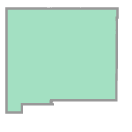

## Generating 10 random points of the attack

In [6]:
#Function Adapted from Professor Pappalardo Voronoi tessellation Function
#generating random points inside the borders
def polygon_random_points(poly):
    min_x, min_y, max_x, max_y = poly.bounds 
    points = []
    while len(points) < 10:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append([random_point.x, random_point.y])
    return np.array(points)

random_attacks = MultiPoint(polygon_random_points(nm_poly))

## Computing the convex hull and the centroid of the area
To get the minimum polygon containing the attack points I computed the convex hull.</br>
Then to get to the possible lab position I computed the centroid of the convex hull

In [7]:
minimum_possible_area = random_attacks.convex_hull
meth_lab = minimum_possible_area.centroid #this is where the DEA thinks the lab is

## Saving New Mexico, Convex hull and Attacks Points to a collection

In [ ]:
nm_attack_lab = GeometryCollection([nm_poly, minimum_possible_area, random_attacks])
nm_attack_lab

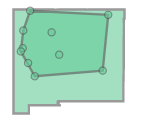

## Plotting the result

In [9]:
#these are the coordinates that I had to adjust when not using a GeoJson to plot:

#to set the starting location I used the new mexico centroid
lat = list(nm_poly.centroid.coords)[0][1]
lng = list(nm_poly.centroid.coords)[0][0]

#to set the meth lab Marker coordinates
lab_lat = list(meth_lab.coords)[0][1]
lab_lng = list(meth_lab.coords)[0][0]

In [ ]:
mappa = folium.Map(location = (lat, lng), zoom_start = 7)
folium.GeoJson(nm_attack_lab).add_to(mappa)
#I used a different marker for the meth lab location
folium.Marker(location=(lab_lat, lab_lng), 
              popup='METH LAB ACCORDING TO DEA\n'+str(meth_lab), 
              icon=folium.Icon(color='red')).add_to(mappa)
mappa

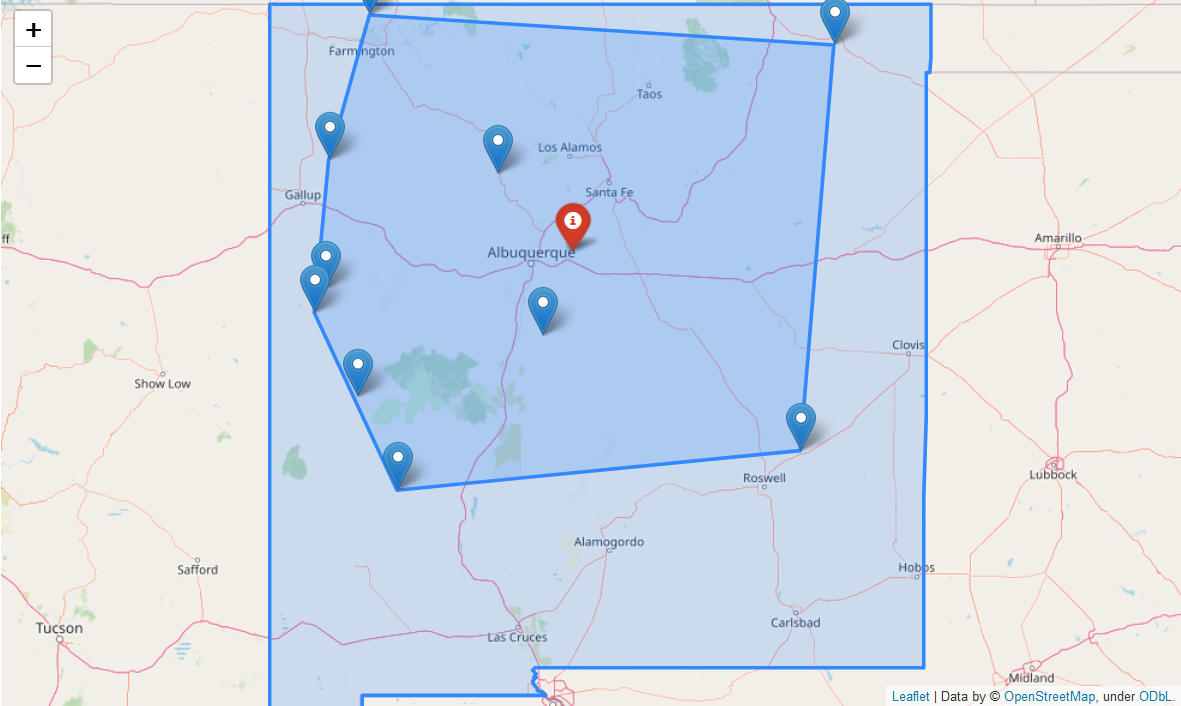